In [ ]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.models import Model, load_model


from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess = tf.Session()
K.set_session(sess)

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)


# Глобальные константы
batch_size = 64
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 8
num_classes = 10
dropout_rate = 0.3
gamma = 1 # Коэффициент гамма


# Итераторы тренировочных и тестовых батчей
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)


# Входные плейсхолдеры
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),  name='image')
y_ = tf.placeholder(tf.float32, shape=(None, 10), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

Instructions for updating:
non-resource variables are not supported in the long term


11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(lbl)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])

In [ ]:
def apply_bn_relu_and_dropout(x, bn=False, relu=True, dropout=True):
    if bn:
        x = BatchNormalization(momentum=0.99, scale=False)(x)
    if relu:
        x = LeakyReLU()(x)
    if dropout:
        x = Dropout(dropout_rate)(x)
    return x

In [ ]:
with tf.variable_scope('encoder'):
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2, 2), padding='same')(x)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    x = Flatten()(x)
    x = concatenate([x, lbl])
    
    h = Dense(64)(x)
    h = apply_bn_relu_and_dropout(h)

    z_mean    = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(K.clip(z_log_var/2, -2, 2)) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model([img, lbl], [z_mean, z_log_var, l], name='Encoder')


with tf.variable_scope('decoder'):
    x = concatenate([z, lbl])
    x = Dense(7*7*128)(x)
    x = apply_bn_relu_and_dropout(x)
    x = Reshape((7, 7, 128))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = apply_bn_relu_and_dropout(x)
    
    decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
decoder = Model([z, lbl], decoded, name='Decoder')


with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)
    x = add_units_to_conv2d(x, lbl)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    # l-слой на котором будем сравнивать активации
    l = Conv2D(16, kernel_size=(3, 3), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], [d, l], name='Discriminator')

In [ ]:
z_mean, z_log_var, encoded_img = encoder([img, lbl])

decoded_img = decoder([encoded_img, lbl])
decoded_z   = decoder([z,           lbl])

discr_img,     discr_l_img     = discrim([img,         lbl])
discr_dec_img, discr_l_dec_img = discrim([decoded_img, lbl])
discr_dec_z,   discr_l_dec_z   = discrim([decoded_z,   lbl])

cvae_model = Model([img, lbl], decoder([encoded_img, lbl]), name='cvae')
cvae =  cvae_model([img, lbl])

In [ ]:
def step(image, label, zp):
    l_prior, dec_image, l_dis_llike, l_gan, _, _ = sess.run([L_prior, decoded_z, L_dis_llike, L_GAN, step_enc, step_dec],
                                                            feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_prior, dec_image, l_dis_llike, l_gan

def step_d(image, label, zp):
    l_gan, _ = sess.run([L_GAN, step_dis], feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_gan

In [ ]:
L_prior = -0.5*tf.reduce_sum(1. + tf.clip_by_value(z_log_var, -2, 2) - tf.square(z_mean) - tf.exp(tf.clip_by_value(z_log_var, -2, 2)))/28/28

log_dis_img     = tf.log(discr_img + 1e-10)
log_dis_dec_z   = tf.log(1. - discr_dec_z + 1e-10)
log_dis_dec_img = tf.log(1. - discr_dec_img + 1e-10)

L_GAN = -1/4*tf.reduce_sum(log_dis_img + 2*log_dis_dec_z + log_dis_dec_img)/28/28

L_dis_llike = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.sigmoid(discr_l_img),
                                                                    logits=discr_l_dec_img))/28/28


L_enc = L_dis_llike + L_prior 
L_dec = gamma * L_dis_llike - L_GAN
L_dis = L_GAN

optimizer_enc = tf.train.RMSPropOptimizer(0.001)
optimizer_dec = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.001)

encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
discrim_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")

step_enc = optimizer_enc.minimize(L_enc, var_list=encoder_vars)
step_dec = optimizer_dec.minimize(L_dec, var_list=decoder_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
digit_size = 28
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, label] = 1
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_decoded = sess.run(decoded_z, feed_dict={z:z_sample, lbl:input_lbl, K.learning_phase():0})
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


def draw_z_distr(z_predicted):
    im = plt.scatter(z_predicted[:, 0], z_predicted[:, 1])
    im.axes.set_xlim(-5, 5)
    im.axes.set_ylim(-5, 5)
    plt.show()
    

def on_n_period(period):
    n_compare = 10

    clear_output()
    b = next(test_batches_it)
    decoded = sess.run(cvae, feed_dict={img:b[0], lbl:b[1], K.learning_phase():0})
    plot_digits(b[0][:n_compare], decoded[:n_compare])

    # Рисование многообразия для рандомного y
    draw_lbl = np.random.randint(0, num_classes)    
    print(draw_lbl)
    for label in range(num_classes):
        figs[label].append(draw_manifold(label, show=label==draw_lbl))

    xs = x_test[y_test == draw_lbl]
    ys = y_test_cat[y_test == draw_lbl]
    z_predicted = sess.run(z_mean, feed_dict={img:xs, lbl:ys, K.learning_phase():0})
    draw_z_distr(z_predicted)
    
    periods.append(period)

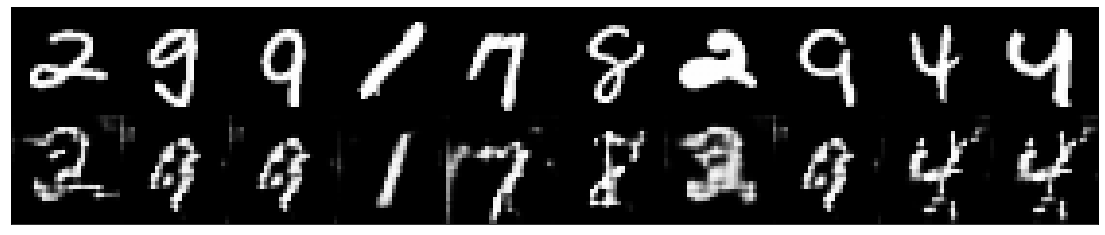

2


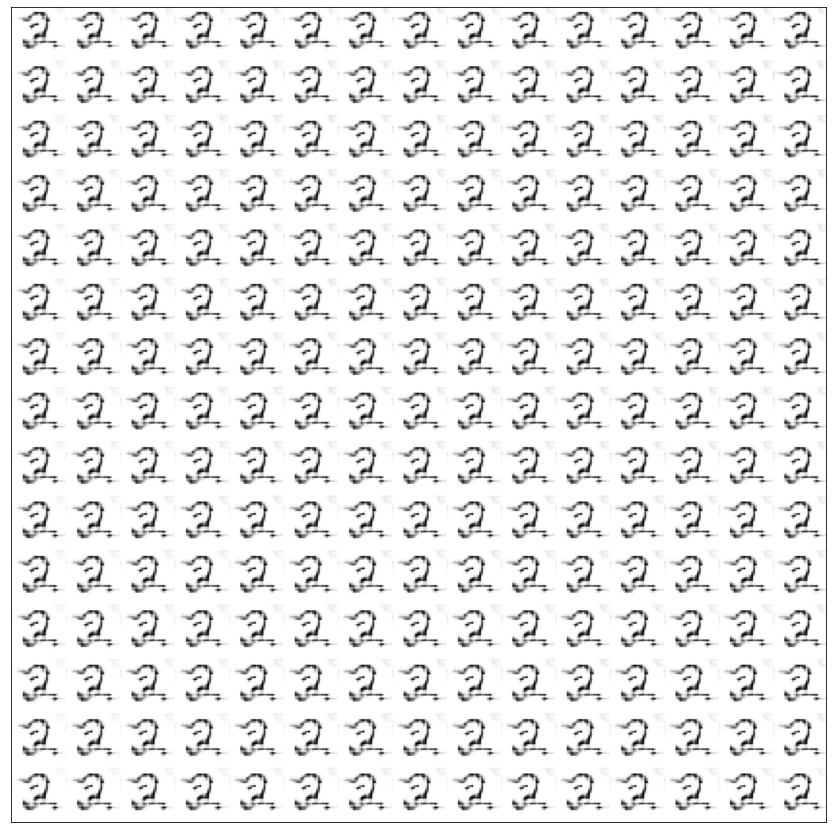

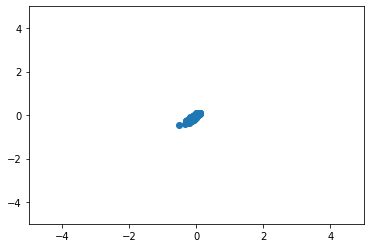

1590 0.0055359313 14.253997 0.000113003895
...

KeyboardInterrupt: ignored

In [ ]:
sess.run(tf.global_variables_initializer())

nb_step = 3

batches_per_period = 3
for i in range(48000):
    print('.', end='')

    for j in range(nb_step):
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        l_g = step_d(b0, b1, zp)
        if l_g < 1.0:
            break
        
    for j in range(nb_step):
        l_p, zx, l_d, l_g = step(b0, b1, zp)
        if l_g > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(i, l_p, l_d, l_g)